# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [8]:
def evalSWE(ds, obs):
#     color = kgraph.SRON(ds.expID.size)
    color = sns.color_palette('Set1', ds.expID.size)
    # SWE
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    for n, ex in enumerate(ds.expID):
        ax.plot(ds.time, ds.sel(expID=ex).scalarSWE, label=ex.values, color=color[n])
    ax.set_ylabel('SWE (mm)')
    plt.legend(loc='best')
    return fig
    
def evalSurfTemp(dsIn, obs, axmin=-30, vmax=20):
    # Colors
    cmin = 0
    cmax = vmax
    ncol = 7
    dcol = (cmax - cmin) / (ncol - 1)
    cmap = sns.cubehelix_palette(ncol, start=2.6, rot=.075, light=0.8, as_cmap=True)
    cmap = kgraph.cmap_discretize(cmap, ncol)
    
    # Tsurf scatter plot
    numExp = dsIn.expID.values.size
    if numExp <= 4:
        fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)
        axes = axes.flatten()
        lastRow = 2
    elif (numExp > 4) and (numExp <= 9):
        fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
        axes = axes.flatten()
        lastRow = 6
    elif numExp > 9:
        fig, axes = plt.subplots(3, 4, figsize=(10.5, 8), sharex=True, sharey=True)
        axes = axes.flatten()
        lastRow = 8
    
    for nEx, ex in enumerate(dsIn.expID):
        ax = axes[nEx]
        
        ds = dsIn.sel(expID=ex)
        ds['Tsrf'] = obs.Tsrf
        ds['scalarSurfaceTemp'] = ds['scalarSurfaceTemp'] - 273
        
        Y = ds.scalarSurfaceTemp
        X = obs.Tsrf
        H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(axmin, 0, 1.5),
                                                       np.arange(axmin, 0, 1.5)))
        H = np.ma.masked_array(H, H < 1)
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax)
        
        ax.plot([axmin, 0], [axmin, 0], 'k--')
        if nEx >= lastRow:
            ax.set_xlabel('Obs Ts')
        ax.set_ylabel('Model Ts')
        ax.set_xlim(axmin, 0)
        ax.set_ylim(axmin, 0)
        ax.grid()
        ax.set_title(ex.values)
        
        binTs = np.arange(axmin, 0, 1)
        groupModelTs = proxyGroupby(ds, 'Tsrf', binTs, 'scalarSurfaceTemp')
        ax.plot(binTs, groupModelTs, 'r')
    fig.autofmt_xdate()
    return fig

# Group a variable according to a proxy variable (e.g., group air temperature according to the stability)
def proxyGroupby(ds, binVar, binVals, digitVar):
    proxyGroups = np.digitize(ds[binVar].values, binVals, right=False)
    groupVar = np.zeros(np.size(binVals))
    for bnum, bV in enumerate(binVals):
        groupVar[bnum] = np.nanmean(ds[digitVar][proxyGroups == bnum])
    return groupVar

def evalDiurnalTs(ds, obs):
    color = kgraph.SRON(ds.expID.size)
    # Tsurf scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    hours = np.arange(0, 24)
    for n, ex in enumerate(ds.expID):
        temp = ds.sel(expID=ex)
        ax.plot(hours, temp.scalarSurfaceTemp.groupby('time.hour').mean(dim='time') - 273.15,
                label=ex.values, color=color[n])
    ax.plot(hours, obs.snowTs.groupby('time.hour').mean(dim='time'), 'k', linewidth=3, label='Obs.')
    ax.plot([0, 23], [0, 0], color='.5')
    ax.set_xlim(0, 23)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('T ($^{\circ}$)')
    plt.legend(loc='best')
    return fig

## Evaluation data

In [4]:
os.chdir(dirData)
SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(datetime(2006, 10, 1), datetime(2012, 9, 30, 23, 0, 0)))]
SWAforce_daily = xr.open_dataset('SWA.ModTsfc.Daily.nc')
SWAforce_daily = SWAforce_daily.loc[dict(time = slice(datetime(2006, 10, 1), datetime(2012, 9, 30, 23, 0, 0)))]

## Model output

In [5]:
os.chdir(dirData + '/summaResults')
SWA = xr.open_dataset('SWA.summaResults.intBias.nc')

## Experiment names

In [6]:
siteNames = ['SWA']
siteYears = {'SWA': np.arange(2006, 2012)}

# ----------
# Experiment names and identifiers
experiments = ['intBias_thermalCond', 'intBias_stability']

# Layer
expNames = {'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']}

# Thermal conductivity
expNames['thermalCond'] = ['tyen1965', 'smnv2000_Low', 'smnv2000_Mid', 'smnv2000_High']

# Stability
expNames['stability'] = ['standard_Low', 'standard_High', 'mahrtexp_Low', 'mahrtexp_High']

# Make experiment names list
expID_dict = {}
for exp in experiments:
    expID_dict[exp] = []

    if 'stability' in exp:
        for layer in expNames['layers']:
            for stab in expNames['stability']:
                # Name for identifying files for this experiment
                expID = layer + '_' + stab
                expID_dict[exp].append(expID)

    elif 'thermalCond' in exp:
        for layer in expNames['layers']:
            for thCond in expNames['thermalCond']:
                # Name for identifying files for this experiment
                expID = layer + '_' + thCond
                expID_dict[exp].append(expID)

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

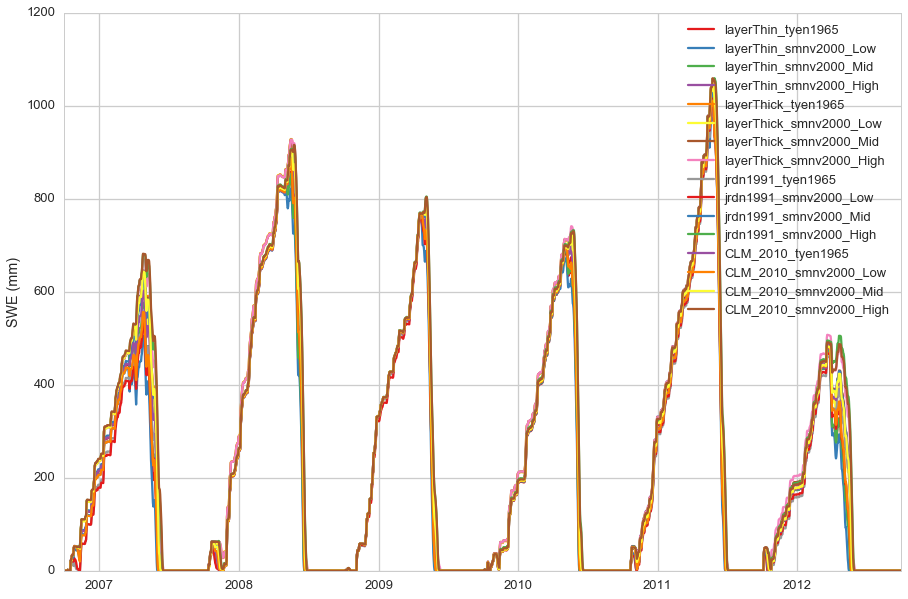

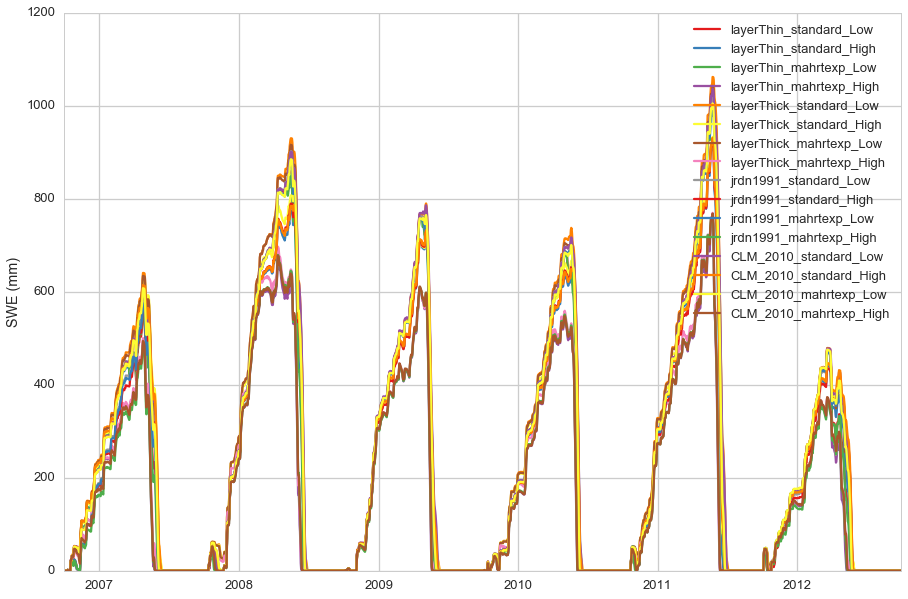

In [9]:
os.chdir(dirPrint)
# Split into SWE and snow depth
for exp in experiments:
    temp = SWA.loc[dict(expID=expID_dict[exp])]
    tempDaily = temp.resample(freq='D', how='mean', dim='time')
    fig = evalSWE(tempDaily, SWAforce)
    fig.savefig('SWE.SWA.All.' + exp + '.pdf')


//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py

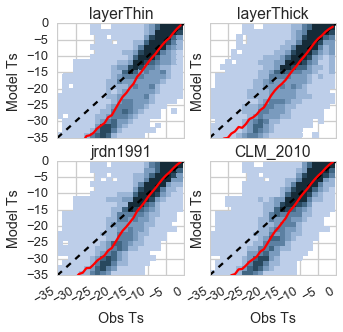

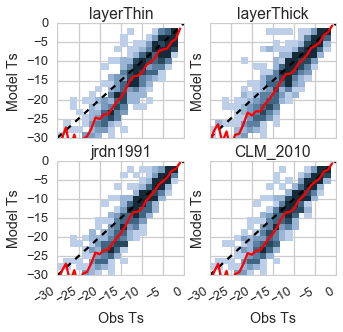

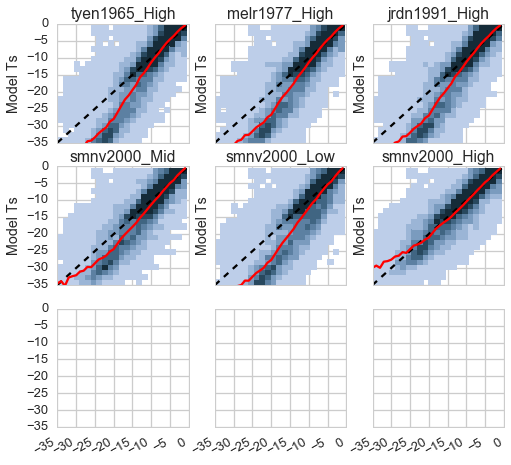

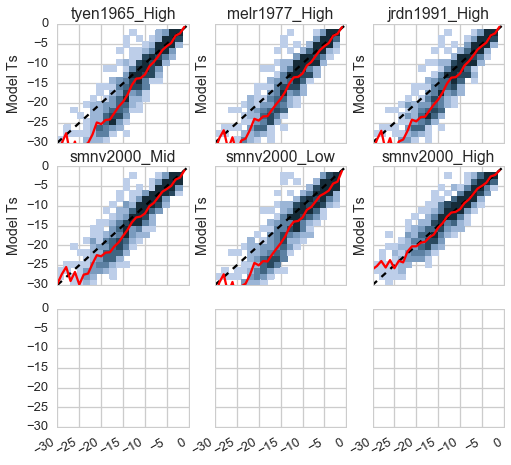

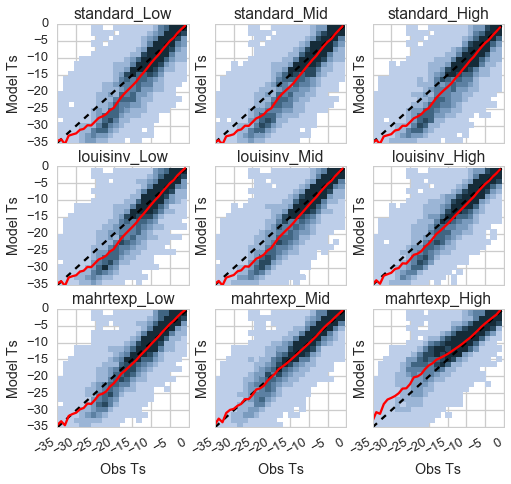

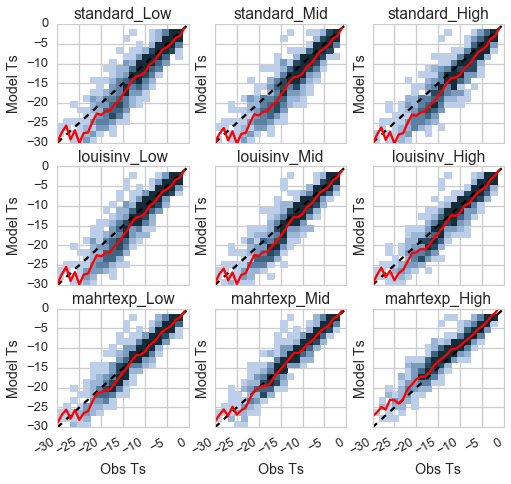

In [19]:
# 2D histograms of observed vs modeled Tsurf with average values
# Internal modeling decisions
for exp in experiments_internal:
    temp = SWA_internal.loc[dict(expID=expNames[exp])]
    tempDaily = temp.resample(freq='D', how='mean', dim='time')
    
    fig = evalSurfTemp(temp, SWA, axmin=-35, vmax=200)
    fig.savefig('2Dhist_Ts.SWA.All.' + exp + '.pdf')

    fig = evalSurfTemp(tempDaily, SWA_daily, axmin=-30, vmax=20)
    fig.savefig('2Dhist_Ts.SWA.All_daily.' + exp + '.pdf')

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py

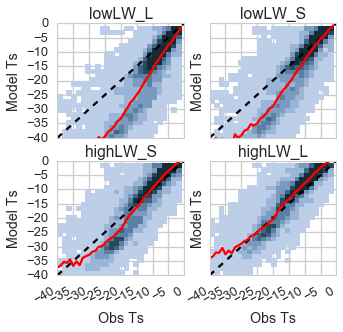

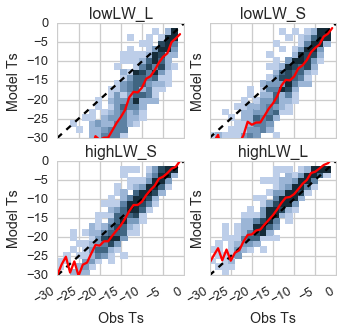

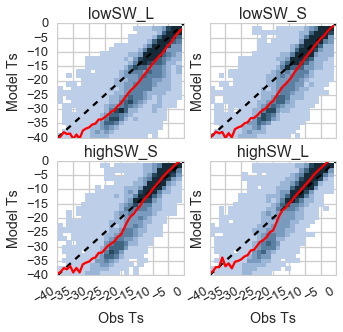

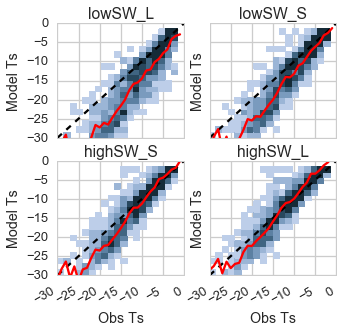

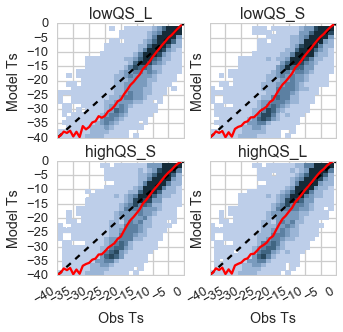

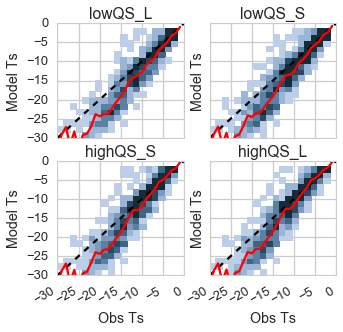

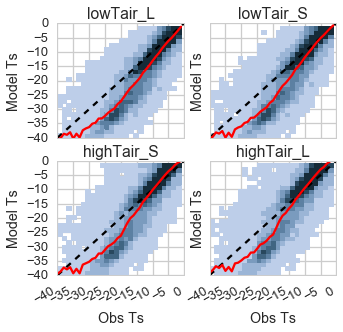

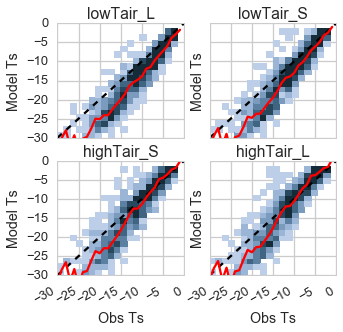

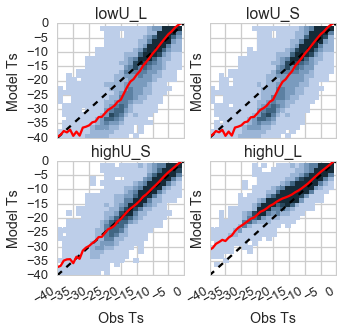

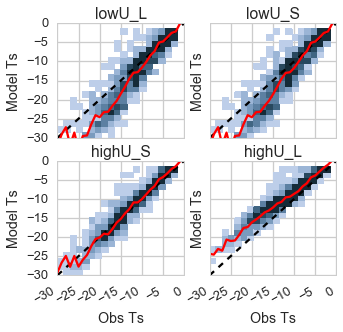

In [20]:
# 2D histograms of observed vs modeled Tsurf with average values
# Forcing data uncertainty
for exp in experiments_forcing:
    temp = SWA_forcing.loc[dict(expID=expNames[exp])]
    tempDaily = temp.resample(freq='D', how='mean', dim='time')
    fig = evalSurfTemp(temp, SWA, axmin=-40, vmax=200)
    fig.savefig('2Dhist_Ts.SWA.All.' + exp + '.pdf')

    fig = evalSurfTemp(tempDaily, SWA_daily, axmin=-30, vmax=20)
    fig.savefig('2Dhist_Ts.SWA.All_daily.' + exp + '.pdf')